# UCLA Master in Quantitative Economics 
## Replication File for <i>Re-estimating the Effect of Skill Specificity on Anti-Immigration Attitudes: A Double/Debiased Machine Learning Approach<i>
### Author: Nathan Kim 
### Faculty Advisor: Denis Chetverikov

In [1]:
# Standard modules 
import random
import numpy as np 
import pandas as pd 
from scipy.stats import norm 
import matplotlib.pyplot as plt

In [2]:
# Linear, tree-based, and ensemble models 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression, Lasso

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 

from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [3]:
# dmlc XGBoost 
import xgboost as xgb

In [4]:
# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

# Data import & cleaning 

In [5]:
# Import data
df = pd.read_stata('gsp_data_final.dta')

In [6]:
# Treatment group should be unemployed sometime during 2003 to 2005
print(df.loc[df['treated'] == 1]['unemployed2'].unique())
print(df.loc[df['treated'] == 1]['syear'].unique())

[1.]
[2004 2003 2005]


In [7]:
# Subsetting data 
df = df[['syear', 'pid', 'concern_rec', 'treated', 'unemployed2', 'income','manualwork',
         'gender', 'age', 'temporary', 'educyears', 'skillsp', 'our']]

In [8]:
# Sort by surveyee ID and survey year 
df = df.sort_values(by=['pid', 'syear'])

In [9]:
df.head()

,syear,pid,concern_rec,treated,unemployed2,income,manualwork,gender,age,temporary,educyears,skillsp,our
0,1999,201,2.0,0.0,0.0,NaN,0.0,2.0,73.0,0.0,11.0,NaN,NaN
1,2000,201,2.0,0.0,0.0,NaN,0.0,2.0,74.0,0.0,10.5,NaN,NaN
2,2001,201,NaN,0.0,0.0,NaN,0.0,2.0,75.0,0.0,10.5,NaN,NaN
3,2002,201,1.0,0.0,0.0,NaN,0.0,2.0,76.0,0.0,10.5,NaN,NaN
4,2003,201,2.0,0.0,0.0,NaN,0.0,2.0,77.0,0.0,10.5,NaN,NaN


In [10]:
# Number of observations each year 
df.dropna().groupby(by='syear').size()

syear
1999     1374
2000    12248
2001     2119
2002    12220
2003     1700
2004    11028
2005     1453
2006     2408
2007    10419
2008     1699
2009    10289
2010     1458
2011    10294
2012     2682
2013     9619
2014     2453
dtype: int64

In [11]:
# Dataframe containing only the years 2003, 2004, and 2005 (i.e. treatment period)
time_frame = df.loc[(df['syear'] == 2003) | (df['syear'] == 2004) | (df['syear'] == 2005)]

In [12]:
# Verifying the above code
print(time_frame['syear'].unique())

[2003 2004 2005]


In [13]:
# Sort by surveyee ID and survey year 
time_frame = time_frame.sort_values(by=['pid', 'syear'])

In [14]:
time_frame.head()

,syear,pid,concern_rec,treated,unemployed2,income,manualwork,gender,age,temporary,educyears,skillsp,our
4,2003,201,2.0,0.0,0.0,NaN,0.0,2.0,77.0,0.0,10.5,NaN,NaN
5,2004,201,3.0,0.0,0.0,NaN,0.0,2.0,78.0,0.0,10.5,NaN,NaN
6,2005,201,1.0,0.0,0.0,NaN,0.0,2.0,79.0,0.0,10.5,NaN,NaN
14,2003,203,2.0,0.0,0.0,4.0,0.0,1.0,43.0,0.0,18.0,NaN,NaN
15,2004,203,2.0,1.0,1.0,NaN,0.0,1.0,44.0,0.0,18.0,NaN,NaN


In [15]:
# Find IDs of surveyees that were unemployed (treated) during 2003-2005 
treated_id = list(time_frame.loc[time_frame['unemployed2'] == 1]['pid'].unique())

In [16]:
# Verifying the above code 
(treated_id == list(df.loc[df['treated'] == 1]['pid'].unique()))

True

In [17]:
# Find IDs of surveyees that were employed all throughout 2003-2005 (control)
control_2003 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2003)]['pid'].unique())
control_2004 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2004)]['pid'].unique())
control_2005 = list(time_frame.loc[(time_frame['unemployed2'] == 0) & (time_frame['syear'] == 2005)]['pid'].unique())

In [18]:
control_id = list(set(control_2003) & set(control_2004) & set(control_2005))

In [19]:
# Treated and control groups are mutually exclusive 
bool(set(treated_id) & set(control_id))

False

In [20]:
# All IDs including both treated and control groups
relevant_id = treated_id + control_id

In [21]:
# 1 == male, 2 == female 
# Replace 2 with 0 to create 'male' dummy variable 
df['gender'] = df['gender'].replace(2, 0)

In [22]:
# Slice dataframe with years 2002 and 2011

# Before treatment = 2002 
# After treatment = 2011

df_2002 = df.loc[df['syear'] == 2002].dropna()
df_2002 = df_2002.loc[df_2002['pid'].isin(relevant_id)]

df_2011 = df.loc[df['syear'] == 2011].dropna()
df_2011 = df_2011.loc[df_2011['pid'].isin(relevant_id)]

In [23]:
# Each year does not have the same number of surveyees/same surveyee IDs  
syear_id = list(df_2002.loc[df_2002['pid'].isin(df_2011['pid'])]['pid'])

In [24]:
df = df.loc[(df['pid'].isin(syear_id)) & ((df['syear'] == 2002) | (df['syear'] == 2011))].reset_index(drop=True)

In [25]:
df['treated'] = 0 
df.loc[df['pid'].isin(treated_id), 'treated'] = 1

In [26]:
df.head()

,syear,pid,concern_rec,treated,unemployed2,income,manualwork,gender,age,temporary,educyears,skillsp,our
0,2002,901,2.0,0,0.0,2.0,0.0,0.0,51.0,0.0,10.5,0.617639,9.205261
1,2011,901,2.0,0,0.0,3.0,0.0,0.0,60.0,0.0,10.5,0.490324,8.017141
2,2002,1501,1.0,0,0.0,3.0,0.0,1.0,44.0,0.0,18.0,0.719778,3.658580
3,2011,1501,1.0,0,0.0,5.0,0.0,1.0,53.0,0.0,18.0,0.708843,2.422332
4,2002,2301,2.0,0,0.0,5.0,0.0,1.0,56.0,0.0,18.0,0.719778,3.658580


In [27]:
df.tail()

,syear,pid,concern_rec,treated,unemployed2,income,manualwork,gender,age,temporary,educyears,skillsp,our
9091,2011,8249801,1.0,0,0.0,4.0,0.0,1.0,55.0,0.0,18.0,0.708843,2.422332
9092,2002,8249802,2.0,0,0.0,4.0,0.0,0.0,43.0,0.0,17.0,0.719778,3.658580
9093,2011,8249802,1.0,0,0.0,5.0,0.0,0.0,52.0,0.0,18.0,0.708843,2.422332
9094,2002,8249803,1.0,0,0.0,1.0,0.0,1.0,21.0,1.0,13.0,3.047472,11.855548
9095,2011,8249803,1.0,0,0.0,2.0,0.0,1.0,30.0,1.0,18.0,0.708843,2.422332


In [28]:
df.shape

(9096, 13)

# Parallel Trends

In [29]:
trends_df = pd.read_stata('gsp_data_final.dta')

In [30]:
trends_id = list(trends_df.loc[trends_df['unemployed2'] == 1]['pid'].unique())

In [31]:
trends_df = trends_df.groupby(by=['syear', 'unemployed2'])[['dv', 'concern_rec']].mean()

In [32]:
trends_0 = trends_df.loc[trends_df.index.get_level_values('unemployed2') == 0].reset_index(level=[0,1])
trends_1 = trends_df.loc[trends_df.index.get_level_values('unemployed2') == 1].reset_index(level=[0,1])

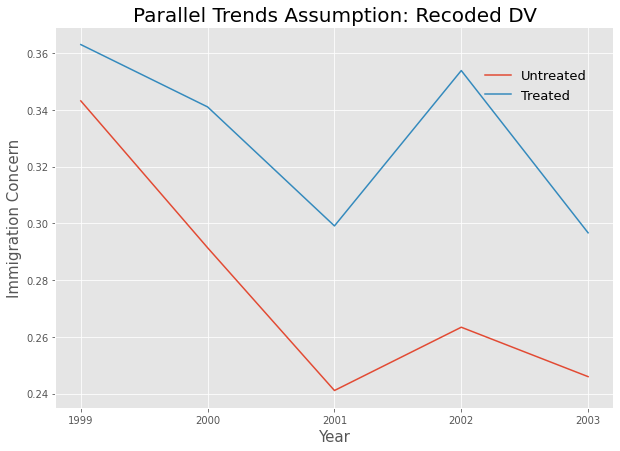

In [33]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 7))
plt.plot(trends_0['syear'][0:5], trends_0['dv'][0:5], label='Untreated')
plt.plot(trends_1['syear'][0:5], trends_1['dv'][0:5], label='Treated')
plt.xticks(np.arange(1999, 2004, 1, dtype=int))
plt.title('Parallel Trends Assumption: Recoded DV', fontsize=20)
plt.ylabel('Immigration Concern', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.legend(loc=(0.76, 0.79), prop={'size' : 13}, frameon=False)
plt.show()

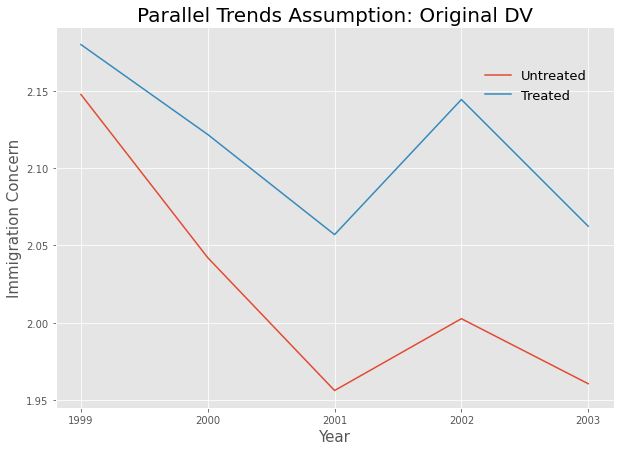

In [34]:
plt.figure(figsize=(10, 7))
plt.plot(trends_0['syear'][0:5], trends_0['concern_rec'][0:5], label='Untreated')
plt.plot(trends_1['syear'][0:5], trends_1['concern_rec'][0:5], label='Treated')
plt.xticks(np.arange(1999, 2004, 1, dtype=int))
plt.title('Parallel Trends Assumption: Original DV', fontsize=20)
plt.ylabel('Immigration Concern', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.legend(loc=(0.76, 0.79), prop={'size' : 13}, frameon=False)
plt.show()

# DMLDiD Estimator

In [35]:
def DMLDiD(Y_1, Y_0, D, X, g_ML, mu_ML):
    
    Y_1 = Y_1.reshape(-1, 1) # Reshape arrays to 2D 
    Y_0 = Y_0.reshape(-1, 1) # ""
    D = D.reshape(-1, 1)     # ""
    
    df = np.concatenate((Y_1, Y_0, D, X), axis=1) # Combine everything into one 2D array 
    
    np.random.seed(123) # Set seed for replicability
    np.random.shuffle(df) # Shuffle data 
    
    K = 2 # Number of folds for cross-fitting 
    N = Y_1.shape[0] # Number of individuals (observations)
    n = round(df.shape[0] / K) # Number of approx observations for each fold
    
    df_I_k = [df[:n, :], df[n:, :]] # List of partions/folds
    
    att_I_k, var_I_k = [], [] # Empty lists to hold results for each fold 
    
    for df_k in df_I_k: # For each fold calculate DMLDiD 
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        prop_score = g_ML.fit(X, D)
        g_hat = prop_score.predict_proba(X)[:, 1]
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
      
        cond_mean = mu_ML.fit(X_mu, Y_1_mu - Y_0_mu)
        mu_hat = cond_mean.predict(X)
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        t0 = ((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))
        
        c1 = ((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat
        
        att_k = np.mean(t0 - c1)
        
        att_I_k.append(att_k)
    
    theta = np.mean(att_I_k)
    
    for df_k in df_I_k: # For each fold calculate variance
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        prop_score = g_ML.fit(X, D)
        g_hat = prop_score.predict_proba(X)[:, 1]
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
        
        cond_mean = mu_ML.fit(X_mu, Y_1_mu - Y_0_mu)
        mu_hat = cond_mean.predict(X)
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        psi = (((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))) - theta
        psi = psi - (((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat)

        G = (-1 * theta) / p_hat
    
        var_k = np.mean((psi + (G * (D - p_hat))) ** 2)
        
        var_I_k.append(var_k)
        
    sigma = np.mean(var_I_k)
    
    return theta, np.sqrt(sigma / N)

# Belloni-Chen-Chernozhukov-Hansen Rule

In [36]:
def bcch_rule(X, Y, c, alpha):
    Y = np.array(Y).reshape(-1, 1)
    X = np.array(X)
    
    n, p = len(Y), X.shape[1]
    
    max_pilot = np.max(np.mean((X ** 2) * (Y ** 2), axis=0)) ** 0.5
    lambda_pilot = ((2 * c) / np.sqrt(n)) * norm.ppf(1 - (alpha / (2 * p))) * max_pilot
    
    lasso_pilot = Lasso(alpha=lambda_pilot, fit_intercept=False).fit(X, Y)
    
    residuals = Y - lasso_pilot.predict(X).reshape(-1, 1)
    
    max_bcch = np.max(np.mean((X ** 2) * (residuals ** 2), axis=0)) ** 0.5
    lambda_bcch = ((2 * c) / np.sqrt(n)) * norm.ppf(1 - (alpha / (2 * p))) * max_bcch
    
    return lambda_bcch

# Setting up data for DMLDiD estimation

In [37]:
D = np.array(df.loc[df['syear'] == 2002, 'treated'])

In [38]:
np.mean(D)

0.08003518029903255

In [39]:
X = np.array(df.loc[df['syear'] == 2002, ['income', 'manualwork', 'gender', 'age', 
                                          'temporary', 'educyears', 'skillsp', 'our']])

In [40]:
X_scaled = np.hstack((X[:, [1, 2, 4]], StandardScaler().fit_transform(X[:, [0, 3, 5, 6, 7]])))

In [41]:
Y_0 = np.array(df.loc[df['syear'] == 2002, 'concern_rec'])
Y_1 = np.array(df.loc[df['syear'] == 2011, 'concern_rec'])

In [42]:
df = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X), axis=1)

In [43]:
X_mu = df[np.where(df[:, 2] == 0)][:, 3:]

In [44]:
df_scaled = np.concatenate((Y_1.reshape(-1, 1), Y_0.reshape(-1, 1), D.reshape(-1, 1), X_scaled), axis=1)

In [45]:
X_mu_scaled = df_scaled[np.where(df_scaled[:, 2] == 0)][:, 3:]

In [46]:
Y_0_mu = df[np.where(df[:, 2] == 0)][:, 1]
Y_1_mu = df[np.where(df[:, 2] == 0)][:, 0]

# DMLDiD Estimation 

## Random Forest 

In [47]:
p_max = X.shape[1]
params = {'max_depth'    : np.linspace(1, 10, 10, dtype=int),
          'max_features' : np.linspace(1, p_max, int(p_max), dtype=int)}

In [48]:
rf_cv_clf = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                         param_grid=params, scoring='neg_log_loss', cv=2).fit(X, D)

In [49]:
rf_cv_clf.best_params_

{'max_depth': 5, 'max_features': 3}

In [50]:
rf_cv_reg = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                         param_grid=params, scoring='neg_mean_squared_error', cv=2).fit(X_mu, Y_1_mu - Y_0_mu)

In [51]:
rf_cv_reg.best_params_

{'max_depth': 2, 'max_features': 3}

In [52]:
md_cv_clf = rf_cv_clf.best_params_['max_depth'] 
mf_cv_clf = rf_cv_clf.best_params_['max_features']

In [53]:
md_cv_reg = rf_cv_reg.best_params_['max_depth']
mf_cv_reg = rf_cv_reg.best_params_['max_features']

In [54]:
g_ML = RandomForestClassifier(random_state=0, 
                              max_depth=md_cv_clf, 
                              max_features=mf_cv_clf)

In [55]:
mu_ML = RandomForestRegressor(random_state=0, 
                              max_depth=md_cv_reg,
                              max_features=mf_cv_reg)

In [56]:
DMLDiD(Y_1, Y_0, D, X, g_ML, mu_ML)

(-0.019381360393685418, 0.04497076628111012)

## Logit-L1 & LASSO

In [57]:
params = {'C' : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

In [58]:
logit_cv = GridSearchCV(estimator=LogisticRegression(random_state=0, penalty='l1', solver='saga', max_iter=10000),
                        param_grid=params, scoring='neg_log_loss', cv=2).fit(X_scaled, D)

In [59]:
logit_cv.best_params_

{'C': 0.5}

In [60]:
C_cv = logit_cv.best_params_['C']

In [61]:
g_ML = LogisticRegression(random_state=0, penalty='l1', solver='saga', C=C_cv, max_iter=10000)

In [62]:
c, alpha = 1.1, 0.05

In [63]:
hyp = bcch_rule(X_mu_scaled, Y_1_mu - Y_0_mu, c, alpha)

In [64]:
hyp 

0.07634254140794522

In [65]:
mu_ML = Lasso(random_state=0, alpha=hyp)

In [66]:
DMLDiD(Y_1, Y_0, D, X, g_ML, mu_ML)

(-0.018058187863270844, 0.046235710448472106)

## Gradient Boosting

In [67]:
params = {'max_depth'     : [1, 2, 3], 
          'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
          'n_estimators'  : [100, 200, 300, 400, 500],
          'max_features'  : [3, 4, 5, 6, 7, 8]}

In [68]:
gb_cv_clf = GridSearchCV(estimator=GradientBoostingClassifier(random_state=0),
                         param_grid=params, scoring='neg_log_loss', cv=2).fit(X, D)

In [69]:
gb_cv_clf.best_params_

{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}

In [70]:
gb_cv_reg = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
                         param_grid=params, scoring='neg_mean_squared_error', cv=2).fit(X_mu, Y_1_mu - Y_0_mu)

In [71]:
gb_cv_reg.best_params_

{'learning_rate': 0.1, 'max_depth': 1, 'max_features': 3, 'n_estimators': 100}

In [72]:
md_cv_clf = gb_cv_clf.best_params_['max_depth'] 
lr_cv_clf = gb_cv_clf.best_params_['learning_rate'] 
ne_cv_clf = gb_cv_clf.best_params_['n_estimators']
mf_cv_clf = gb_cv_clf.best_params_['max_features'] 

In [73]:
md_cv_reg = gb_cv_reg.best_params_['max_depth'] 
lr_cv_reg = gb_cv_reg.best_params_['learning_rate']
ne_cv_reg = gb_cv_reg.best_params_['n_estimators']
mf_cv_reg = gb_cv_reg.best_params_['max_features'] 

In [74]:
g_ML = GradientBoostingClassifier(random_state=0,
                                  max_depth=md_cv_clf,
                                  learning_rate=lr_cv_clf,
                                  n_estimators=ne_cv_clf, 
                                  max_features=mf_cv_clf)

In [75]:
mu_ML = GradientBoostingRegressor(random_state=0,
                                  max_depth=md_cv_reg, 
                                  learning_rate=lr_cv_reg,
                                  n_estimators=ne_cv_reg, 
                                  max_features=mf_cv_reg)

In [76]:
DMLDiD(Y_1, Y_0, D, X, g_ML, mu_ML)

(-0.010925395993200398, 0.04582410113156102)

## Neural Networks 

In [77]:
def DMLDiD_TF(Y_1, Y_0, D, X, g_ML, mu_ML):
    
    # Same function as DMLDiD() but for TensorFlow 
    
    Y_1 = Y_1.reshape(-1, 1) # Reshape arrays to 2D 
    Y_0 = Y_0.reshape(-1, 1) # ""
    D = D.reshape(-1, 1)     # ""
    
    df = np.concatenate((Y_1, Y_0, D, X), axis=1) # Combine everything into one 2D array 
    
    np.random.seed(123) # Set seed for replicability
    tf.random.set_seed(123)
    
    np.random.shuffle(df) # Shuffle data 
    
    K = 2 # Number of folds for cross-fitting 
    N = Y_1.shape[0] # Number of individuals (observations)
    n = round(df.shape[0] / K) # Number of approx observations for each fold
    
    df_I_k = [df[:n, :], df[n:, :]] # List of partions/folds
    
    att_I_k, var_I_k = [], [] # Empty lists to hold results for each fold 
    
    for df_k in df_I_k: # For each fold calculate DMLDiD 
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        prop_score = g_ML.fit(X, D, verbose=0, batch_size=32, epochs=20, validation_split=0.3)
        g_hat = prop_score.model.predict(X).reshape(-1, )
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
      
        cond_mean = mu_ML.fit(X_mu, Y_1_mu - Y_0_mu, verbose=0, 
                              batch_size=32, epochs=20, validation_split=0.3)
        mu_hat = cond_mean.model.predict(X).reshape(-1, )
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        t0 = ((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))
        
        c1 = ((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat
        
        att_k = np.mean(t0 - c1)
        
        att_I_k.append(att_k)
    
    theta = np.mean(att_I_k)
    
    for df_k in df_I_k: # For each fold calculate variance
        D, X = df_k[:, 2], df_k[:, 3:]
        
        p_hat = np.mean(D)
        
        prop_score = g_ML.fit(X, D, verbose=0, batch_size=32, epochs=20, validation_split=0.3)
        g_hat = prop_score.model.predict(X).reshape(-1, )
        
        df_mu = df_k[np.where(df_k[:, 2] == 0)]
        
        Y_1_mu, Y_0_mu, X_mu = df_mu[:, 0], df_mu[:, 1], df_mu[:, 3:]
        
        cond_mean = mu_ML.fit(X_mu, Y_1_mu - Y_0_mu, verbose=0, 
                              batch_size=32, epochs=20, validation_split=0.3)
        mu_hat = cond_mean.model.predict(X).reshape(-1, )
        
        Y_1, Y_0 = df_k[:, 0], df_k[:, 1]
    
        psi = (((Y_1 - Y_0) / p_hat) * ((D - g_hat) / (1 - g_hat))) - theta
        psi = psi - (((D - g_hat) / (p_hat * (1 - g_hat))) * mu_hat)

        G = (-1 * theta) / p_hat
    
        var_k = np.mean((psi + (G * (D - p_hat))) ** 2)
        
        var_I_k.append(var_k)
        
    sigma = np.mean(var_I_k)
    
    return theta, np.sqrt(sigma / N)

In [78]:
def plot_loss(history, title):
    plt.figure(figsize=(7, 4))
    plt.title('Loss Convergence for ' + title)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Function')
    plt.legend()
    plt.grid(True)

In [79]:
def build_model(mspec, optimizer, lr, clf):

    model = keras.Sequential() # Feedforward neural network 
    
    model.add(layers.Dense(units=mspec[0], activation='relu', input_shape=(8,))) # First hidden layer, input layer = 8 units 
    
    opt = tf.keras.optimizers.SGD(learning_rate=lr) # Use stochastic GD by default 
    
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=lr) # Use Adam if specified 
    
    for m in mspec[1:]:
        model.add(layers.Dense(units=m, activation='relu')) 
        
    if clf:
        model.add(layers.Dense(units=1, activation='sigmoid')) # Sigmoid output for classification 
        model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])
    else: 
        model.add(layers.Dense(units=1))
        model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mse']) 
        
    return model 

In [80]:
def grid_search(mspecs, optimizers, lrates, X, y, clf): 
    
    random.seed(123)
    np.random.seed(123)
    tf.random.set_seed(123)
    
    hidden_layers, lrate_values, loss_values, opt_names = [], [], [], [] 
    
    kf = KFold(n_splits=2, random_state=0, shuffle=True)
    
    if clf:
        kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True) 
    
    for o in optimizers:
        for m in mspecs:
            for lr in lrates: 

                model = build_model(m, o, lr, clf) 

                fold_loss = [] 

                for train_idx, test_idx in kf.split(X, y):
                    model.fit(X[train_idx], y[train_idx], batch_size=32, epochs=20, verbose=0)

                    loss, metric = model.evaluate(X[test_idx], y[test_idx], verbose=0)
                    fold_loss.append(loss)

                mean_loss = np.mean(fold_loss)

                hidden_layers.append(m)
                opt_names.append(o)
                lrate_values.append(lr)
                loss_values.append(mean_loss)
        
        
    return pd.DataFrame({'Model'     : hidden_layers, 
                         'Optimizer' : opt_names,
                         'Alpha'     : lrate_values, 
                         'Loss'      : loss_values})

In [81]:
optimizers = ['sgd', 'adam']
lrates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
mspecs = [[6, 4, 2], [6, 4], [6]]

In [82]:
nn_cv_clf = grid_search(mspecs, optimizers, lrates, X_scaled, D, clf=True)

In [83]:
nn_cv_reg = grid_search(mspecs, optimizers, lrates, X_mu_scaled, Y_1_mu - Y_0_mu, clf=False)

In [84]:
nn_cv_clf.iloc[np.argmin(nn_cv_clf['Loss']), :]

Model          [6, 4]
Optimizer         sgd
Alpha             0.1
Loss         0.249029
Name: 10, dtype: object

In [85]:
nn_cv_reg.iloc[np.argmin(nn_cv_reg['Loss']), :]

Model        [6, 4, 2]
Optimizer         adam
Alpha            0.001
Loss          0.602556
Name: 20, dtype: object

In [86]:
idx_clf = np.argmin(nn_cv_clf['Loss'])
idx_reg = np.argmin(nn_cv_reg['Loss'])

In [87]:
mspec_cv_clf = nn_cv_clf.iloc[idx_clf, 0]
opt_cv_clf = nn_cv_clf.iloc[idx_clf, 1]
lr_cv_clf = nn_cv_clf.iloc[idx_clf, 2]

In [88]:
mspec_cv_reg = nn_cv_reg.iloc[idx_reg, 0]
opt_cv_reg = nn_cv_reg.iloc[idx_reg, 1]
lr_cv_reg = nn_cv_reg.iloc[idx_reg, 2]

In [89]:
g_ML = build_model(mspec_cv_clf, opt_cv_clf, lr_cv_clf, clf=True)

In [90]:
mu_ML = build_model(mspec_cv_reg, opt_cv_reg, lr_cv_reg, clf=False)

In [91]:
DMLDiD_TF(Y_1, Y_0, D, X_scaled, g_ML, mu_ML)

(-0.0138658554751988, 0.04552190441042893)

## XGBoost

In [92]:
params = {'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
          'n_estimators'  : [100, 200, 300, 400, 500],
          'reg_lambda'    : [0.1, 0.5, 1],
          'reg_alpha'     : [0.1, 0.5, 1],
          'max_depth'     : [1, 2, 3]}

In [93]:
xgb_cv_clf = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=0),
                          param_grid=params, scoring='neg_log_loss', cv=2).fit(X, D)

In [94]:
xgb_cv_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 100,
 'reg_alpha': 1,
 'reg_lambda': 0.5}

In [95]:
xgb_cv_reg = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=0),
                          param_grid=params, scoring='neg_mean_squared_error', cv=2).fit(X_mu, Y_1_mu - Y_0_mu)

In [96]:
xgb_cv_reg.best_params_

{'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 200,
 'reg_alpha': 1,
 'reg_lambda': 1}

In [97]:
lr_cv_clf = xgb_cv_clf.best_params_['learning_rate'] 
ne_cv_clf = xgb_cv_clf.best_params_['n_estimators']
md_cv_clf = xgb_cv_clf.best_params_['max_depth']
lb_cv_clf = xgb_cv_clf.best_params_['reg_lambda']
ap_cv_clf = xgb_cv_clf.best_params_['reg_alpha']

In [98]:
lr_cv_reg = xgb_cv_reg.best_params_['learning_rate']
ne_cv_reg = xgb_cv_reg.best_params_['n_estimators']
md_cv_reg = xgb_cv_reg.best_params_['max_depth']
lb_cv_reg = xgb_cv_reg.best_params_['reg_lambda']
ap_cv_reg = xgb_cv_reg.best_params_['reg_alpha']

In [99]:
g_ML = xgb.XGBClassifier(objective='binary:logistic',  
                         random_state=0,
                         learning_rate=lr_cv_clf,
                         n_estimators=ne_cv_clf, 
                         max_depth=md_cv_clf,
                         reg_lambda=lb_cv_clf, 
                         reg_alpha=ap_cv_clf)

In [100]:
mu_ML = xgb.XGBRegressor(objective='reg:squarederror', 
                         random_state=0,
                         max_depth=md_cv_reg, 
                         learning_rate=lr_cv_reg,
                         n_estimators=ne_cv_reg, 
                         reg_lambda=lb_cv_reg, 
                         reg_alpha=ap_cv_reg)

In [101]:
DMLDiD(Y_1, Y_0, D, X, g_ML, mu_ML)

(-0.010229952767504907, 0.045619182479158686)

## AdaBoost

In [102]:
params_clf = {'learning_rate'  : [0.0001, 0.001, 0.01, 0.1, 1],
              'n_estimators'   : [100, 200, 300, 400, 500],
              'base_estimator' : [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                                  DecisionTreeClassifier(max_depth=3)]}

In [103]:
ada_cv_clf = GridSearchCV(estimator=AdaBoostClassifier(random_state=0),
                          param_grid=params_clf, scoring='neg_log_loss', cv=2).fit(X, D)

In [104]:
ada_cv_clf.best_params_

{'base_estimator': DecisionTreeClassifier(max_depth=3),
 'learning_rate': 0.001,
 'n_estimators': 100}

In [105]:
params_reg = {'learning_rate'  : [0.0001, 0.001, 0.01, 0.1, 1],
              'n_estimators'   : [100, 200, 300, 400, 500],
              'base_estimator' : [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=2), 
                                  DecisionTreeRegressor(max_depth=3)]}

In [106]:
ada_cv_reg = GridSearchCV(estimator=AdaBoostRegressor(random_state=0),
                          param_grid=params_reg, scoring='neg_mean_squared_error', cv=2).fit(X_mu, Y_1_mu - Y_0_mu)

In [107]:
ada_cv_reg.best_params_

{'base_estimator': DecisionTreeRegressor(max_depth=2),
 'learning_rate': 0.0001,
 'n_estimators': 200}

In [108]:
lr_cv_clf = ada_cv_clf.best_params_['learning_rate'] 
ne_cv_clf = ada_cv_clf.best_params_['n_estimators']
be_cv_clf = ada_cv_clf.best_params_['base_estimator']

In [109]:
lr_cv_reg = ada_cv_reg.best_params_['learning_rate']
ne_cv_reg = ada_cv_reg.best_params_['n_estimators']
be_cv_reg = ada_cv_reg.best_params_['base_estimator']

In [110]:
g_ML = AdaBoostClassifier(random_state=0,
                          learning_rate=lr_cv_clf,
                          n_estimators=ne_cv_clf, 
                          base_estimator=be_cv_clf)

In [111]:
mu_ML = AdaBoostRegressor(random_state=0,
                          base_estimator=be_cv_reg, 
                          learning_rate=lr_cv_reg,
                          n_estimators=ne_cv_reg)

In [112]:
DMLDiD(Y_1, Y_0, D, X, g_ML, mu_ML)

(-0.00922013415858038, 0.04827530855017655)